In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import scipy.io
mat = scipy.io.loadmat('/content/imagelabels.mat')
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import random
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt



In [ ]:
import scipy.io
mat = scipy.io.loadmat('/content/imagelabels.mat')
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import random
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt



In [ ]:


# Set the paths
dataset_path = '/content/drive/MyDrive/Applied ML 3/jpg'
train_path = '/content/drive/MyDrive/Applied ML 3/train'
val_path = '/content/drive/MyDrive/Applied ML 3/validation'
test_path = '/content/drive/MyDrive/Applied ML 3/test'

# Set the random seed for reproducibility
random.seed(42)

# Create directories for train, validation, and test sets
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Perform the random split twice
for split in range(2):
    print(f'Split {split + 1}')

    # Get the list of category directories in the dataset
    category_dirs = os.listdir(dataset_path)
    category_dirs = sorted(category_dirs, key=lambda x: int(x.split('_')[1].split('.')[0]))
    cat_tup=[]
    for index in range(len(category_dirs)):
        cat_tup.append((category_dirs[index],mat['labels'][0][index]))

    # Randomly shuffle the category directories
    random.shuffle(cat_tup)

    # Divide the dataset into training, validation, and test sets
    train_split_size = int(0.5 * len(cat_tup))
    val_split_size = int(0.25 * len(cat_tup))
    test_split_size = len(cat_tup) - train_split_size - val_split_size


    if(split==0):
          train_categories_1 = cat_tup[:train_split_size]
          val_categories_1 = cat_tup[train_split_size:train_split_size+val_split_size]
          test_categories_1 = cat_tup[train_split_size+val_split_size:]

    if(split==1):
          train_categories_2 = cat_tup[:train_split_size]
          val_categories_2 = cat_tup[train_split_size:train_split_size+val_split_size]
          test_categories_2 = cat_tup[train_split_size+val_split_size:]

    print('Dataset split completed.')
    print('-' * 30)

Split 1
Dataset split completed.
------------------------------
Split 2
Dataset split completed.
------------------------------


In [ ]:
x_train = []
y_train = []
new_train=[]

#for image_name, number in train_categories_1:
for image_name, number in train_categories_1:
    x_train.append('/content/drive/MyDrive/Applied ML 3/jpg/' + image_name)
    y_train.append(number)
    new_train.append(('/content/drive/MyDrive/Applied ML 3/jpg/' + image_name,str(number)))

new_train = pd.DataFrame(new_train, columns=['image_path', 'label'])

In [ ]:
x_val = []
y_val = []
new_val=[]

for image_name, number in val_categories_1:
    x_val.append('/content/drive/MyDrive/Applied ML 3/jpg/' + image_name)
    y_val.append(number)
    new_val.append(('/content/drive/MyDrive/Applied ML 3/jpg/' + image_name,str(number)))

new_val = pd.DataFrame(new_val, columns=['image_path', 'label'])


In [ ]:
x_test = []
y_test = []
new_test=[]
for image_name, number in test_categories_1:
    x_test.append('/content/drive/MyDrive/Applied ML 3/jpg/' + image_name)
    y_test.append(number)
    new_test.append(('/content/drive/MyDrive/Applied ML 3/jpg/' + image_name,str(number)))

new_test = pd.DataFrame(new_test, columns=['image_path', 'label'])

In [ ]:

# Preprocess and augment the data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=new_train,  # Pandas DataFrame with 'image_path' and 'label' columns
    x_col='image_path',  # Column name containing the image paths
    y_col='label',  # Column name containing the labels
    target_size=(224, 224),  # Resize images to a consistent size
    batch_size=64,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=new_val,  # Pandas DataFrame with 'image_path' and 'label' columns
    x_col='image_path',  # Column name containing the image paths
    y_col='label',  # Column name containing the labels
    target_size=(224, 224),  # Resize images to a consistent size
    batch_size=64,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=new_test,  # Pandas DataFrame with 'image_path' and 'label' columns
    x_col='image_path',  # Column name containing the image paths
    y_col='label',  # Column name containing the labels
    target_size=(224, 224),  # Resize images to a consistent size
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False to preserve the order of images and labels
)

Found 4094 validated image filenames belonging to 102 classes.
Found 2047 validated image filenames belonging to 102 classes.
Found 2048 validated image filenames belonging to 102 classes.


In [ ]:
# def build_vgg19(num_units, learning_rate):
#     # Create a VGG19 model
#     base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#     # Freeze the base model's layers
#     for layer in base_model.layers:
#         layer.trainable = False

#     # Create a new model
#     model = Sequential()
#     model.add(base_model)
#     model.add(Flatten())
#     model.add(Dense(num_units, activation='relu'))
#     #model.add(Dense(4096, activation='relu'))
#     model.add(Dense(102, activation='softmax'))
#     optimizer = Adam(learning_rate=learning_rate)

#     # Compile the model
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#     return model

In [ ]:
# np.random.seed(42)

# param_grid = {
#     'num_units': [256, 512],
#     'learning_rate': [0.001, 0.0001]
# }

# model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_vgg19, epochs=10, batch_size=128, verbose=0)



# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
# grid_result = grid_search.fit(train_generator, validation_data=validation_generator)


In [ ]:
# import itertools
# from tensorflow.keras.applications import VGG19
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# # Define the hyperparameters and their possible values
# hyperparameters = {
#     'learning_rate': [0.001, 0.01],
#     'batch_size': [16, 224],
# }

# # Generate all possible combinations of hyperparameter values
# combinations = list(itertools.product(*hyperparameters.values()))

# # Loop through each combination
# for combo in combinations:
#     learning_rate, batch_size= combo

#     # Create the VGG19 model with the current hyperparameters
#     base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

#     # Add your own custom classifier layers on top of the base model
#     # For example:
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(512, activation='relu')(x)
#     predictions = Dense(102, activation='softmax')(x)

#     model = Model(inputs=base_model.input, outputs=predictions)

#     # Compile the model with the current hyperparameters
#     model.compile(optimizer=Adam(learning_rate=learning_rate),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

#     # Train the model on the current hyperparameters
#     #model.fit(new_train["image_path"], new_train["label"], validation_data=(new_val["image_path"], new_val["label"]), batch_size=batch_size, epochs=num_epochs)
#     model.fit(train_generator, validation_data=validation_generator, batch_size=batch_size, epochs=10)

#     # Evaluate the model on the test set
#     loss, accuracy = model.evaluate(test_generator)

#     # Print the hyperparameters and the model's performance
#     print(f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")
#     print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
#     print("--------------------------------------------------")

In [ ]:
# best_model = grid_result.best_estimator_
# test_loss, test_accuracy = best_model.model.evaluate(test_generator)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)

In [ ]:
# Access the best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# num_units = best_params['num_units']
# learning_rate = best_params['learning_rate']


# Create a VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()
model.add(base_model)
model.add(Flatten())
#model.add(Dense(num_units, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(102, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history= model.fit(train_generator, epochs=10, validation_data=validation_generator)


80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/10
64/64 [==============================] - 247s 2s/step - loss: 4.6950 - accuracy: 0.1649 - val_loss: 3.1366 - val_accuracy: 0.3239
Epoch 2/10
64/64 [==============================] - 94s 1s/step - loss: 2.3882 - accuracy: 0.4687 - val_loss: 2.0872 - val_accuracy: 0.5085
Epoch 3/10
64/64 [==============================] - 97s 2s/step - loss: 1.5412 - accuracy: 0.6321 - val_loss: 1.4999 - val_accuracy: 0.6165
Epoch 4/10
64/64 [==============================] - 95s 1s/step - loss: 1.0681 - accuracy: 0.7443 - val_loss: 1.3455 - val_accuracy: 0.6400
Epoch 5/10
64/64 [==============================] - 94s 1s/step - loss: 0.8246 - accuracy: 0.7946 - val_loss: 1.2056 - val_accuracy: 0.6649
Epoch 6/10
64/64 [==============================] - 95s 1s/step - loss: 0.7214 - accuracy: 0.8117 - val_loss: 1.0848 - val_accuracy: 0.7186
Epoch 7/10
64/64 [==============================] - 95s 1s/step - loss: 0.5328 - accuracy: 0.8

In [ ]:
  # Retrieve accuracy and loss values from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

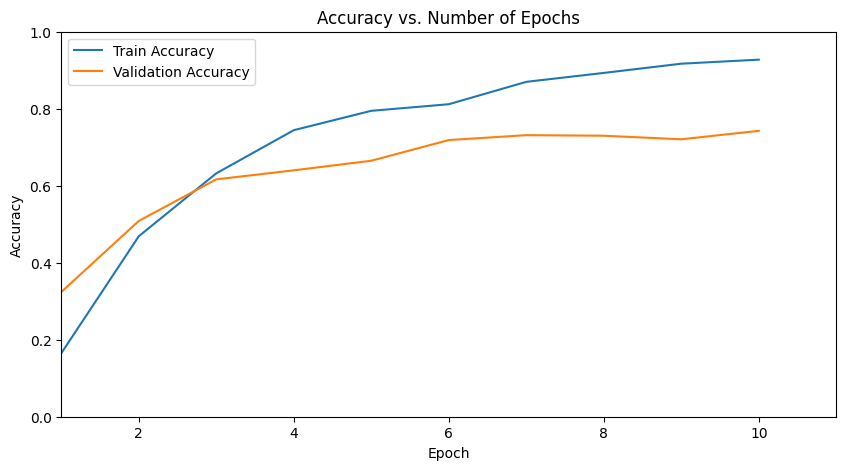

In [ ]:
# Create plots for accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_accuracy, label='Train Accuracy')
plt.plot(range(1, 11), val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs. Number of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(1, 10)  # Specify the range for the x-axis
plt.ylim(0, 1)  # Specify the range for the y-axis
plt.legend()
plt.show()

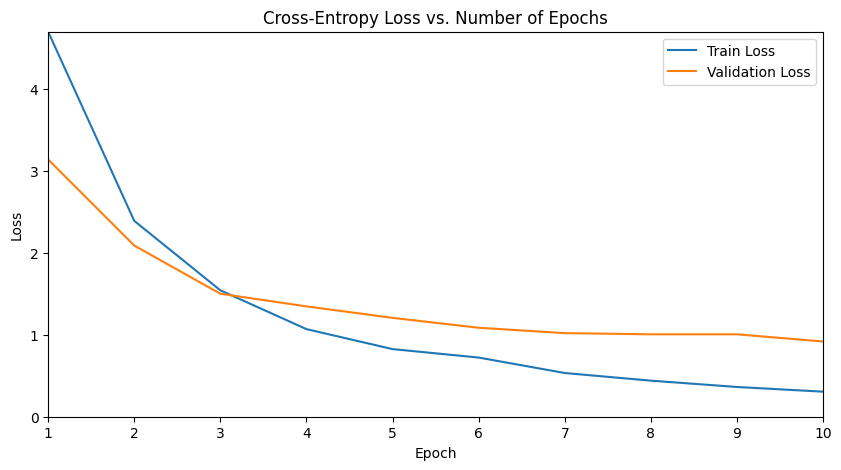

In [ ]:
# Create plots for loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_loss, label='Train Loss')
plt.plot(range(1, 11), val_loss, label='Validation Loss')
plt.title('Cross-Entropy Loss vs. Number of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(1, 10)  # Specify the range for the x-axis
plt.ylim(0,  max(train_loss + val_loss))  # Specify the range for the y-axis
plt.legend()
plt.show()

In [ ]:
x_train = []
y_train = []
new_train=[]

#for image_name, number in train_categories_1:
for image_name, number in train_categories_2:
    x_train.append('/content/drive/MyDrive/Applied ML 3/jpg/' + image_name)
    y_train.append(number)
    new_train.append(('/content/drive/MyDrive/Applied ML 3/jpg/' + image_name,str(number)))

new_train = pd.DataFrame(new_train, columns=['image_path', 'label'])

In [ ]:
x_val = []
y_val = []
new_val=[]

for image_name, number in val_categories_2:
    x_val.append('/content/drive/MyDrive/Applied ML 3/jpg/' + image_name)
    y_val.append(number)
    new_val.append(('/content/drive/MyDrive/Applied ML 3/jpg/' + image_name,str(number)))

new_val = pd.DataFrame(new_val, columns=['image_path', 'label'])


In [ ]:
x_test = []
y_test = []
new_test=[]
for image_name, number in test_categories_2:
    x_test.append('/content/drive/MyDrive/Applied ML 3/jpg/' + image_name)
    y_test.append(number)
    new_test.append(('/content/drive/MyDrive/Applied ML 3/jpg/' + image_name,str(number)))

new_test = pd.DataFrame(new_test, columns=['image_path', 'label'])

In [ ]:

# Preprocess and augment the data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=new_train,  # Pandas DataFrame with 'image_path' and 'label' columns
    x_col='image_path',  # Column name containing the image paths
    y_col='label',  # Column name containing the labels
    target_size=(224, 224),  # Resize images to a consistent size
    batch_size=64,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=new_val,  # Pandas DataFrame with 'image_path' and 'label' columns
    x_col='image_path',  # Column name containing the image paths
    y_col='label',  # Column name containing the labels
    target_size=(224, 224),  # Resize images to a consistent size
    batch_size=64,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=new_test,  # Pandas DataFrame with 'image_path' and 'label' columns
    x_col='image_path',  # Column name containing the image paths
    y_col='label',  # Column name containing the labels
    target_size=(224, 224),  # Resize images to a consistent size
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False to preserve the order of images and labels
)

Found 4094 validated image filenames belonging to 102 classes.
Found 2047 validated image filenames belonging to 102 classes.
Found 2048 validated image filenames belonging to 102 classes.


In [ ]:
# Access the best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# num_units = best_params['num_units']
# learning_rate = best_params['learning_rate']


# Create a VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()
model.add(base_model)
model.add(Flatten())
#model.add(Dense(num_units, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(102, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history= model.fit(train_generator, epochs=10, validation_data=validation_generator)


Epoch 1/10
64/64 [==============================] - 108s 2s/step - loss: 4.4303 - accuracy: 0.1790 - val_loss: 2.6474 - val_accuracy: 0.3874
Epoch 2/10
64/64 [==============================] - 96s 1s/step - loss: 2.1415 - accuracy: 0.5024 - val_loss: 1.8260 - val_accuracy: 0.5613
Epoch 3/10
64/64 [==============================] - 95s 1s/step - loss: 1.4368 - accuracy: 0.6407 - val_loss: 1.4546 - val_accuracy: 0.6180
Epoch 4/10
64/64 [==============================] - 94s 1s/step - loss: 0.9903 - accuracy: 0.7535 - val_loss: 1.2366 - val_accuracy: 0.6707
Epoch 5/10
64/64 [==============================] - 96s 2s/step - loss: 0.7939 - accuracy: 0.7934 - val_loss: 1.1182 - val_accuracy: 0.6961
Epoch 6/10
64/64 [==============================] - 94s 1s/step - loss: 0.6100 - accuracy: 0.8488 - val_loss: 0.9871 - val_accuracy: 0.7396
Epoch 7/10
64/64 [==============================] - 96s 2s/step - loss: 0.4823 - accuracy: 0.8781 - val_loss: 1.0044 - val_accuracy: 0.7513
Epoch 8/10
64/64 [=

In [ ]:
  # Retrieve accuracy and loss values from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

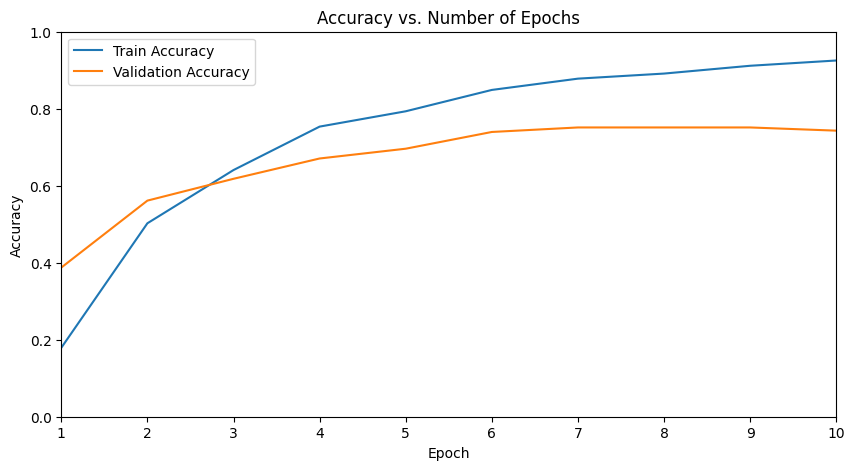

In [ ]:
# Create plots for accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_accuracy, label='Train Accuracy')
plt.plot(range(1, 11), val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs. Number of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(1, 10)  # Specify the range for the x-axis
plt.ylim(0, 1)  # Specify the range for the y-axis
plt.legend()
plt.show()

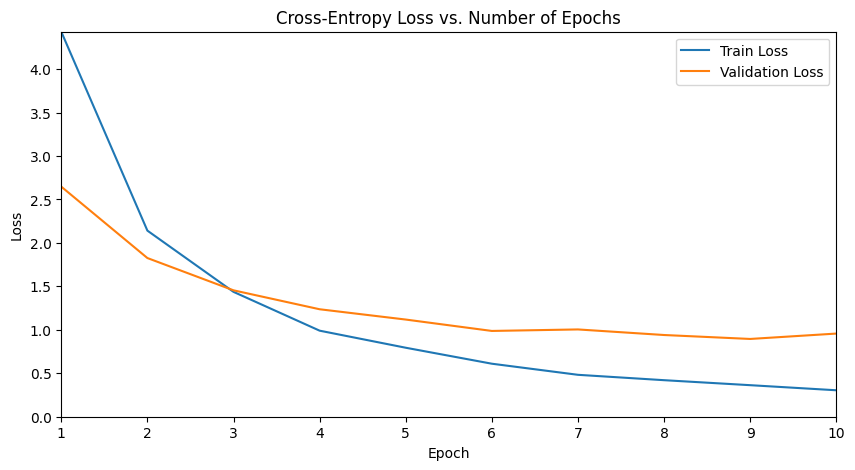

In [ ]:
# Create plots for loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_loss, label='Train Loss')
plt.plot(range(1, 11), val_loss, label='Validation Loss')
plt.title('Cross-Entropy Loss vs. Number of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(1, 10)  # Specify the range for the x-axis
plt.ylim(0,  max(train_loss + val_loss))  # Specify the range for the y-axis
plt.legend()
plt.show()